# Dimensionality Reduction

This notebook explores the Ondřejov dataset using PCA and t-SNE
and some preprocessing algorithms.

## TODO

- t-SNE

In [1]:
%matplotlib inline

In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.decomposition import PCA
import sklearn.preprocessing
import matplotlib
import matplotlib.pyplot as plt
import spectraldl.ondrejov as ondrejov
import astropy.io.fits as fits
from astropy.convolution import Gaussian1DKernel, convolve

In [3]:
# log directory for data serialization
LOG_DIR = '/tb-embedding/'

In [4]:
f = h5py.File('data/data.hdf5')
X = f['X'][...]
y = f['y'][...]
idents = f['idents'][...]

In [5]:
def plot_scatter(X, y):
    '''Plot scatter plot of point from X. X is of shape (n_samples, 2).'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sc = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.25)
    fig.colorbar(sc)

## PCA

Reduce the raw dataset to 2 PCA compenents.
Explained variance is high
but the scatter plot shows that this reduction is useless
because most of the point are close to each other.

explained variance: 93.7947469932356%


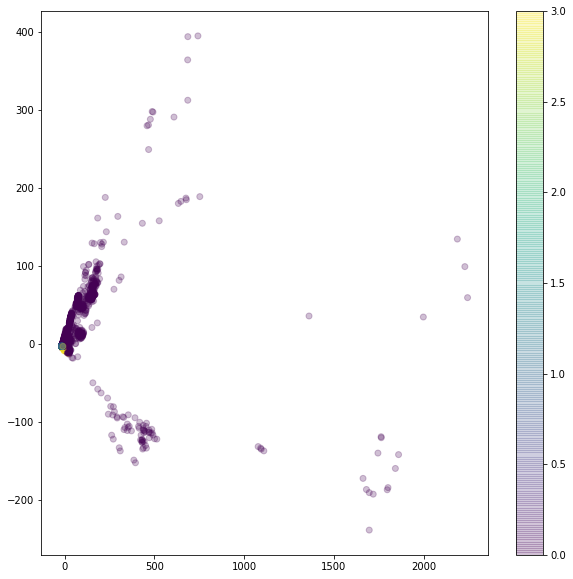

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print('explained variance: {}%'.format(np.sum(pca.explained_variance_ratio_) * 100))
plot_scatter(X_pca, y)

# add identificator to each point
# for idx, ident in enumerate(idents):
#     ax.annotate(ident, (X_pca[idx, 0], X_pca[idx, 1]))

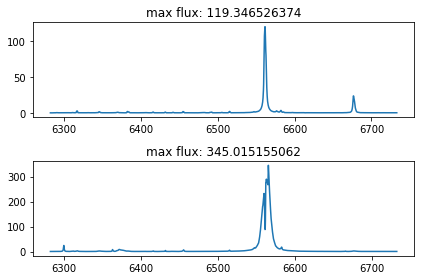

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1)

with fits.open('ssap/ui300025.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax1)
    ax1.set_title('max flux: ' + str(np.max(ondrejov.get_fluxes(hdulist))))

with fits.open('ssap/td260020.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax2)
    ax2.set_title('max flux: ' + str(np.max(ondrejov.get_fluxes(hdulist))))

fig.tight_layout()

If identificator are plotted to the scatter plot
the outliers can be determined.
Two of them are plotted above.
They have really high some fluxes values.

## Scaling Samples

But because in this classfication problem the shape of spectral is the most important
the fluxes intensities can be suppress to some range.

In following code minmax scaler and scaler to zero mean and unit variance are applied
to **each individula spectra**. ATTENTION not applied to each feature.

Aim is to suppress intensieties and so only information about shape remains.

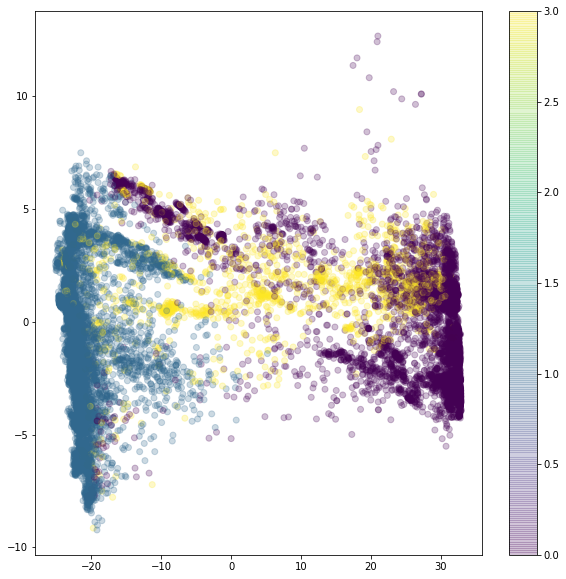

In [8]:
# minmax scale to range (-1, 1)
# axis=1 means to scale individual samples
X_minmax = sklearn.preprocessing.minmax_scale(X, feature_range=(-1, 1), axis=1)
X_minmax_pca = PCA(n_components=2).fit_transform(X_minmax)
plot_scatter(X_minmax_pca, y)

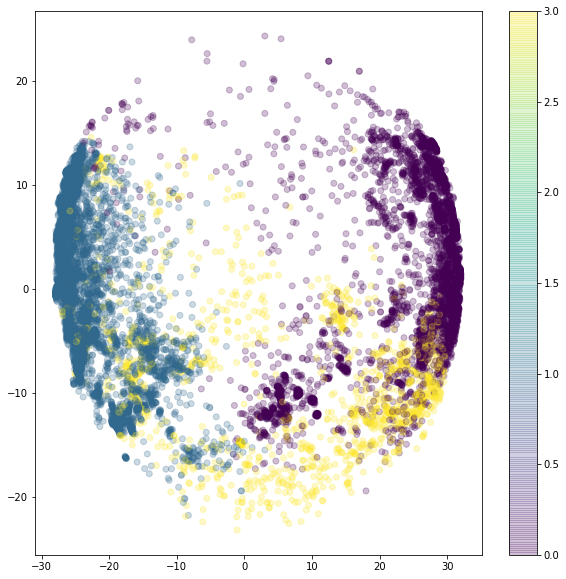

In [9]:
# for np.float32 there are numerical issues
X_scale = sklearn.preprocessing.scale(X.astype(np.float64), axis=1)
X_scale_pca = PCA(n_components=2).fit_transform(X_scale)
plot_scatter(X_scale_pca, y)

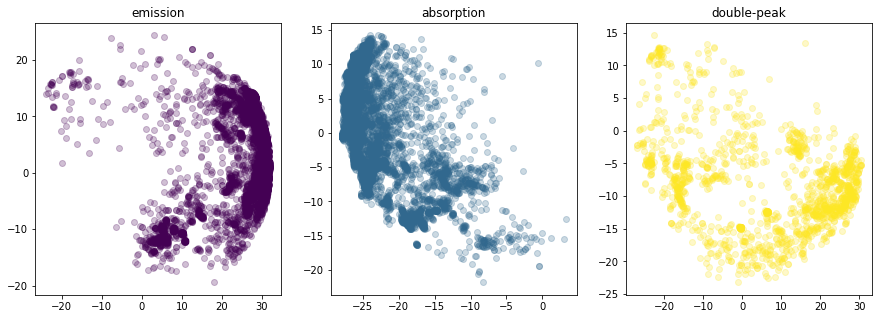

In [10]:
# each class plotted individually
cmap = plt.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

titles = ['emission', 'absorption', 'double-peak']
labels = [0, 1, 3]
colors = [cmap(norm(l)) for l in labels]
for title, label, ax, color in zip(titles, labels, axs, colors):
    ax.set_title(title)
    ax.scatter(X_scale_pca[y == label][:, 0], X_scale_pca[y == label][:, 1], alpha=0.25, c=color)

### Conclusions

Result above are much more promising.
From scatter plot it look relatively easy to separate emission an absorption spectra.
But double-peak spectra are mix randomly in space.
They are maybe better separated when scaled to zero mean and unit varinace.

If we should split to emission and absorption linear separation would work good.
But because the double-peak spectra are not easily separable in above plot
deep network will hopefully find better representation for sepation.

The insight into data then the shape is the main feature helps to
apply dimensionality reduction better therefore it should be used futher.

## Convolution

Let's see how the space look after applying gaussian blur to spectra.

The emission and absorption spectra are still well separated
but double peaks are me hidden in them.
This is expected behavior as covolution convert double-peak spectra to one of other classes.

**It is question how the space of LAMOST spectra looks like.**

In [11]:
X_conv = np.zeros_like(X)
kernel = Gaussian1DKernel(stddev=7)

for i, x in enumerate(X):
    X_conv[i] = convolve(x, kernel, boundary='extend')

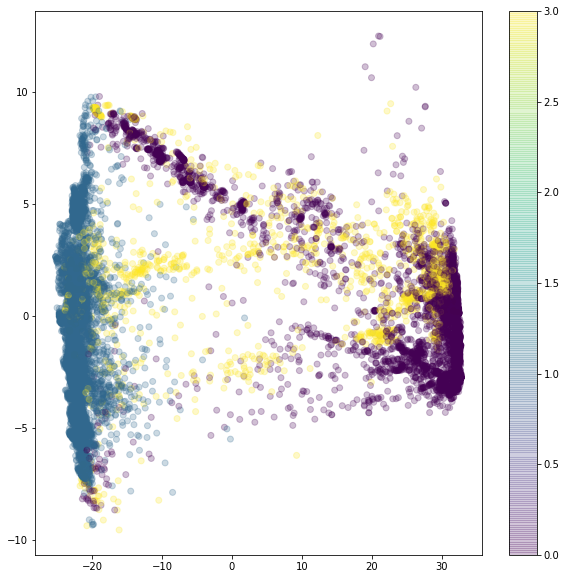

In [12]:
X_conv_minmax = sklearn.preprocessing.minmax_scale(X_conv, feature_range=(-1, 1), axis=1)
X_conv_minmax_pca = PCA(n_components=2).fit_transform(X_conv_minmax)
plot_scatter(X_conv_minmax_pca, y)

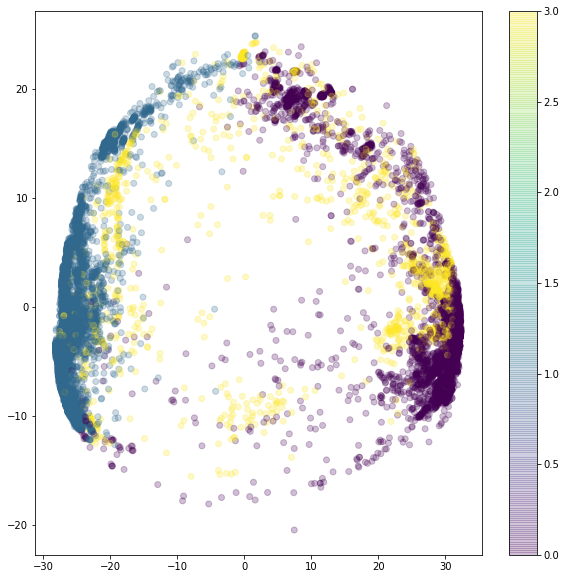

In [13]:
# for np.float32 there are numerical issues
X_conv_scale = sklearn.preprocessing.scale(X_conv.astype(np.float64), axis=1)
X_conv_scale_pca = PCA(n_components=2).fit_transform(X_conv_scale)
plot_scatter(X_conv_scale_pca, y)

## TensorBoard 

TensorBoard provides nice PCA and t-SNE interactive 3D vizualizations.
Tutorial is available at https://www.tensorflow.org/get_started/embedding_viz.
To start TensorBoard in a docker container:

    docker exec -it <container-name> bash
    tensorboard --logdir=/data/podondra/embedding

In [14]:
# start TensorFlow interactive session
sess = tf.InteractiveSession()

In [15]:
# clear the log directory
if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

# instatiate file TF writer
summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

# save labels to metadata.tsv
# format is Tab Separeted Values
# if more then one columns then first row is columns names
np.savetxt(LOG_DIR + 'metadata.tsv', y.reshape(-1, 1), fmt='%d')

# start creating config
config = projector.ProjectorConfig()

# add embeddings
def add_embedding(X, name):
    embedding_var = tf.Variable(tf.constant(X), name=name)
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name
    # link this tensor to its metadata file
    embedding.metadata_path = LOG_DIR + 'metadata.tsv'
    
add_embedding(X, 'norm')

# load the variables
sess.run(tf.global_variables_initializer())
# checkpoint the session
saver = tf.train.Saver()
saver.save(sess, LOG_DIR + 'model.ckpt', 0)

# write config
projector.visualize_embeddings(summary_writer, config)

In [16]:
sess.close()
f.close()